## Project 4: West Nile Virus Detection



### Problem Statement

To analyse weather, location, testing and spraying GIS data to build a statistical model for the **optimal prediction of the presence, time, location and species of West Nile Virus (WNV) in Chicago.**

Concurrently, The Chicago Municipality and Chicago Department of Public Health is interested in identifying the highest number of WNV cases possible (sensitivity) rather than avoid False Positives, (where WNV is predicted but there isn't a case). 

This is due to the high cost of an undetected WNV (due to health implications) as compared to the cost involved in spraying an area with presticide due to a false alarm.

Success is evaluated by ensuring that the model has the **highest Area Under the Curve score**, which signifies that the model is robust enough to allow flexible choice of thresholds. This can be verified on the Kaggle Website.

The Chicago Municipality and Chicago Department of Public Health can choose the model with the **highest sensitivity when WNV is pandemic** and subsequently, model with the **highest precision** when the number of incidences is lower.

### Executive Summary

- West Nile Virus is most commmonly spread through infected mosquitos
- 20% of people who are infected, develop symptoms ranging from fever, to serious neurological illness and death.
- In 2002, first human cases of WNV	were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of	Public Health (CDPH) had established a comprehensive surveillance and control program.
- Every week, mosquitos in traps across the city are tested for the virus. The results of these tests infludence when and where the city will spray pesticides.
- Given weather, location, testing, and spraying data, Chicago Municipality and CDPH 






### Contents:
- [Data Cleaning and Feature Engineering](#Data-Cleaning-and-Feature-Engineering)
- [Explatory Data Analysis and Cleaning](#Explatory-Data-Analysis-and-Cleaning)
- [Modelling and Kaggle Results](#Modelling-and-Kaggle-Results)


In [1]:
#*All libraries used should be added here*
import scipy.stats as scist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_columns', 30)

#Modelling

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from imblearn import under_sampling, over_sampling
from operator import itemgetter

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


## Data Cleaning and Feature Engineering

#### Read in Train and Test Data


In [2]:
trainDf = pd.read_csv('./assets/train.csv')
trainDf.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


Since the lat/long are derived attributes based on address, block, street, etc., we can drop these columns and only use lat/long to determine geo-location.

In [3]:
trainDf.drop(['Address','Block','Street','AddressNumberAndStreet'],axis=1,inplace=True)
trainDf.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0


In [4]:
trainDf.shape

(10506, 8)

The train dataset contains 10506 rows and 12 columns.

In [5]:
trainDf.isnull().sum()

Date               0
Species            0
Trap               0
Latitude           0
Longitude          0
AddressAccuracy    0
NumMosquitos       0
WnvPresent         0
dtype: int64

There are no null values in the train dataset, which simplifies the data cleaning process.

In [6]:
trainDf.describe()

,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,41.841139,-87.699908,7.819532,12.853512,0.052446
std,0.112742,0.096514,1.452921,16.133816,0.222936
min,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,41.954690,-87.627796,9.000000,17.000000,0.000000
max,42.017430,-87.531635,9.000000,50.000000,1.000000


Focus on the 'WnvPresent' column. Based on the information above, the dataset we have is highly inbalanced (only 5% of the rows contain data points which represents the presence of the WNV virus). This would be a problem for our model subsequently; hence, some additional effort would be required to balance out the dataset (e.g. by bootstrapping, oversampling, undersampling, SMOTE)

In [7]:
trainDf.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [8]:
trainDf.dtypes

Date                object
Species             object
Trap                object
Latitude           float64
Longitude          float64
AddressAccuracy      int64
NumMosquitos         int64
WnvPresent           int64
dtype: object

Convert the date column to datetime object so that subsequent operations can be done.

In [9]:
trainDf['Date'] = pd.to_datetime(trainDf['Date'])

In [10]:
trainDf.dtypes

Date               datetime64[ns]
Species                    object
Trap                       object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

**Feature Engineering** - Take Dummies of Species

In [11]:
#Species = trainDf['Species']

In [12]:
#trainDf = pd.get_dummies(trainDf, prefix = ['Species'], columns = ['Species'] ,drop_first = True)

In [13]:
#trainDf = pd.concat([trainDf, Species], axis = 1)
#trainDf.head()

Import spray.csv file which may provide additional insights to the data.

In [14]:
sprayDf = pd.read_csv('./assets/spray.csv')
sprayDf.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [15]:
sprayDf.shape

(14835, 4)

The spray dataset contains 14835 rows and 4 columns.

In [16]:
sprayDf.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

There are some null values in the 'Time' column, but not in the 'Date' column. There is no need to drop any rows since we can just make use of 'Date' for subsequent analysis.

In [17]:
sprayDf.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

Similar to above, convert 'Date' column to datetime object for operations.

In [18]:
sprayDf['Date'] = pd.to_datetime(sprayDf['Date'])

In [19]:
sprayDf.dtypes

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object

Merge trainDf and sprayDf datasets into a single dataset, using the geo-location as match key. Since geo-location has high resolution, we round the lat/long values in both dataframes to 3dp (~= 100 metres). 

In [20]:
trainDf['Latitude'] = trainDf['Latitude'].round(3)
trainDf['Longitude'] = trainDf['Longitude'].round(3)

In [21]:
sprayDf['Latitude'] = sprayDf['Latitude'].round(3)
sprayDf['Longitude'] = sprayDf['Longitude'].round(3)

Aggregate the spraying data points and calculate the count, max, min, peak-to-peak values for each lat/long geo-location.

In [22]:
spray1 = sprayDf.groupby(['Latitude','Longitude'])['Date'].agg(['count','max','min']).reset_index()
spray1['ptp'] = spray1['max'] - spray1['min']
spray1['ptp'] = spray1['ptp'].dt.days
spray1 = spray1.sort_values(by='ptp',ascending=False)
spray1.head()

,Latitude,Longitude,count,max,min,ptp
5908,41.997,-87.811,3,2013-09-05,2011-09-07,729
4374,41.954,-87.784,4,2013-08-16,2013-08-15,1
2527,41.911,-87.750,2,2013-08-16,2013-08-15,1
4454,41.957,-87.784,3,2013-08-16,2013-08-15,1
4704,41.965,-87.782,5,2013-08-16,2013-08-15,1


In [23]:
spray1.tail()

,Latitude,Longitude,count,max,min,ptp
2168,41.893,-87.768,3,2013-08-15,2013-08-15,0
2167,41.893,-87.770,2,2013-08-15,2013-08-15,0
2166,41.893,-87.772,1,2013-08-15,2013-08-15,0
2165,41.892,-87.704,1,2013-08-22,2013-08-22,0
6516,42.396,-88.096,2,2011-08-29,2011-08-29,0


In [24]:
spray1['ptp'].value_counts()

0      6511
1         5
729       1
Name: ptp, dtype: int64

In [25]:
spray1[spray1['ptp']>0]

,Latitude,Longitude,count,max,min,ptp
5908,41.997,-87.811,3,2013-09-05,2011-09-07,729
4374,41.954,-87.784,4,2013-08-16,2013-08-15,1
2527,41.911,-87.750,2,2013-08-16,2013-08-15,1
4454,41.957,-87.784,3,2013-08-16,2013-08-15,1
4704,41.965,-87.782,5,2013-08-16,2013-08-15,1
4703,41.965,-87.783,3,2013-08-16,2013-08-15,1


In [26]:
spray1.to_csv('./assets/spray1.csv',index=False)
sprayDf.to_csv('./assets/sprayDf.csv',index=False)

For most geo-locations, there is only 1 spray date. For those with ptp>1, we will need to examine which dates to use for the subsequent computations.

Do a left merge on the trainDf dataframe. The resulting combined dataframe will have the same number of rows as the trainDf dataframe.

In [27]:
sptraininner=pd.merge(trainDf,spray1,on=['Longitude','Latitude'],how='inner',indicator=True)
sptraininner.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp,_merge
0,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1,2011-09-07,2011-09-07,0,both
1,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,1,2011-09-07,2011-09-07,0,both
2,2007-06-05,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1,2011-09-07,2011-09-07,0,both
3,2007-06-05,CULEX RESTUANS,T015,41.974,-87.825,8,2,0,1,2011-09-07,2011-09-07,0,both
4,2007-06-26,CULEX RESTUANS,T015,41.974,-87.825,8,1,0,1,2011-09-07,2011-09-07,0,both


In [28]:
sptraininner.shape

(963, 13)

In [29]:
sptraininner[sptraininner['ptp']>0]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp,_merge


In [30]:
trainSprayCombined = pd.merge(trainDf,spray1,on=['Latitude','Longitude'],how='left')
trainSprayCombined.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,NaN,NaT,NaT,NaN
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1.0,2011-09-07,2011-09-07,0.0
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,1.0,2011-09-07,2011-09-07,0.0


In [31]:
trainSprayCombined.shape

(10506, 12)

In [32]:
trainSprayCombined[trainSprayCombined['ptp']>0]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp


After merging, there are no more rows with ptp>0. This means that the 'max' and 'min' spray dates are the same for all data points in this combined dataframe.

In [33]:
trainSprayCombined['Date'] = pd.to_datetime(trainSprayCombined['Date'])

**Feature Engineering** to create new column 'Most_Recent_Spray'. This column represents the most recent spray (from sprayDf), in terms of number of days ago, with respect to the data collection date (from trainDf).

In [34]:
trainSprayCombined['Most_Recent_Spray'] = trainSprayCombined['Date']-trainSprayCombined['min']
trainSprayCombined['Most_Recent_Spray'] = trainSprayCombined['Most_Recent_Spray'].dt.days
trainSprayCombined['Most_Recent_Spray'] = trainSprayCombined['Most_Recent_Spray'].apply(lambda x: x if x > 0 else 3650)

Assumption: For rows with no spray record (NaN) and rows with negative recent spray days (which means the spray only occurred after the data collection date), we impute the most recent spray to be 3650 days (10 years ago).

In [35]:
trainSprayCombined[trainSprayCombined['Most_Recent_Spray']<3650]['Most_Recent_Spray'].describe()

count    103.000000
mean     201.300971
std      296.758396
min        1.000000
25%       15.000000
50%       35.000000
75%      642.500000
max      750.000000
Name: Most_Recent_Spray, dtype: float64

In [36]:
trainSprayCombined['Recently_Sprayed'] = (trainSprayCombined['Most_Recent_Spray']<201).astype(int)
trainSprayCombined['Recently_Sprayed'].value_counts()

0    10430
1       76
Name: Recently_Sprayed, dtype: int64

In [37]:
trainSprayCombined.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp,Most_Recent_Spray,Recently_Sprayed
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN,3650.0,0
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN,3650.0,0
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,NaN,NaT,NaT,NaN,3650.0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1.0,2011-09-07,2011-09-07,0.0,3650.0,0
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,1.0,2011-09-07,2011-09-07,0.0,3650.0,0


**Feature Engineering** to create new column 'Recently_Sprayed'. This column represents if the location has been recently sprayed, with the threshold being set to the mean of the column (disregarding the rows where 'Most_Recent_Spray'==3650).

However, based on this criteria, only a small proportion of the locations have been recently sprayed (76 out of 10430). There is very little variance within the column, which means it might not be very useful (to be assessed later in the EDA/modelling parts).

Import weather.csv file which may provide additional insights to the data.

In [38]:
weatherDf = pd.read_csv('./assets/weather.csv')
weatherDf.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [39]:
weatherDf.shape

(2944, 22)

The weatherDf contains 2944 rows and 22 columns.

In [40]:
weatherDf.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

**Feature Engineering** Engineer Tmax, ResultSpeed and AvgSpeed Rolling Averages

In [41]:
weatherDfOHare = weatherDf[weatherDf['Station'] == 1]
weatherDfMidway = weatherDf[weatherDf['Station'] == 2]

In [42]:
weatherDfMidway['Tmax_14dayA'] = weatherDfMidway['Tmax'].rolling(14).mean()
weatherDfMidway.loc[0:28, 'Tmax_14dayA'] = weatherDfMidway.loc[0:28, 'Tmax']
weatherDfMidway['ResultSpeed_14dayA'] = weatherDfMidway['ResultSpeed'].rolling(14).mean()
weatherDfMidway.loc[0:28, 'ResultSpeed_14dayA'] = weatherDfMidway.loc[0:28, 'ResultSpeed']
weatherDfOHare['Tmax_14dayA'] = weatherDfOHare['Tmax'].rolling(14).mean()
weatherDfOHare.loc[0:28, 'Tmax_14dayA'] = weatherDfOHare.loc[0:28, 'Tmax']
weatherDfOHare['ResultSpeed_14dayA'] = weatherDfOHare['ResultSpeed'].rolling(14).mean()
weatherDfOHare.loc[0:28, 'ResultSpeed_14dayA'] = weatherDfOHare.loc[0:28, 'ResultSpeed']
        
        

/Users/vincentlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/vincentlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/vincentlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [43]:
weatherDfMidway.head(20)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tmax_14dayA,ResultSpeed_14dayA
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,84.000000,2.700000
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,60.000000,13.300000
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2,67.000000,12.900000
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4,78.000000,10.100000
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5,66.000000,11.200000
11,2,2007-05-06,68,52,60,M,30,46,5,0,-,-,,M,M,M,0.00,29.62,30.28,13.8,10,14.5,68.000000,13.800000
13,2,2007-05-07,84,50,67,M,39,53,0,2,-,-,,M,M,M,0.00,29.44,30.12,8.5,17,9.9,84.000000,8.500000
15,2,2007-05-08,80,60,70,M,57,63,0,5,-,-,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4,80.000000,2.500000
17,2,2007-05-09,76,63,70,M,60,63,0,5,-,-,BR HZ,M,M,M,0.02,29.28,29.93,3.9,7,5.9,76.000000,3.900000
19,2,2007-05-10,83,59,71,M,52,61,0,6,-,-,BR HZ,M,M,M,0.00,29.26,29.91,2.0,9,3.9,83.000000,2.000000


For now, there seems to be no null values in this dataframe. However, the data dictionary suggests that there might still be missing values, denoted by 'M' or '-' for different columns. This will be examined later.

In [44]:
weatherDf['Date'] = pd.to_datetime(weatherDf['Date'])

The weatherDf dataframe contains information from 2 different weather stations in Chicago:
- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

Before merging this to the combined dataframe (with trainDf and sprayDf), we need to first determine which weather station to use for each row in the combined dataframe. This will be based on distance proximity - using the weather station that is closer to the collection lat/long location.

In [45]:
def calculateDistance(latDelta, longDelta):
    return np.sqrt((latDelta)**2 + (longDelta)**2)

In [46]:
def checkNearerStation(lat,long):
    station1 = {'lat':41.995, 'long':-87.933}
    station2 = {'lat':41.786, 'long':-87.752}
    dist1 = calculateDistance(lat-station1['lat'], long-station1['long'])
    dist2 = calculateDistance(lat-station2['lat'], long-station2['long'])
    if dist1 < dist2:
        station=1
    else:
        station=2
    return station

In [47]:
trainSprayCombinedW = trainSprayCombined.copy()

In [48]:
trainSprayCombinedW['Station'] = trainSprayCombinedW.apply(lambda x: checkNearerStation(x['Latitude'], x['Longitude']),axis=1)

In [49]:
trainSprayCombinedW.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp,Most_Recent_Spray,Recently_Sprayed,Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN,3650.0,0,1
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN,3650.0,0,1
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,NaN,NaT,NaT,NaN,3650.0,0,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1.0,2011-09-07,2011-09-07,0.0,3650.0,0,1
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,1.0,2011-09-07,2011-09-07,0.0,3650.0,0,1


In [50]:
trainSprayCombinedW['Station'].value_counts(normalize=True)

2    0.782696
1    0.217304
Name: Station, dtype: float64

78% of the data collection points are closer to Station 2 in terms of distance proximity.

Merge the weather information to the combined dataframe, using both 'Date' and 'Station' as merge keys.

In [51]:
trainSprayCombinedWeather = pd.merge(trainSprayCombinedW, weatherDf, 
                                     left_on=['Date','Station'], right_on=['Date','Station'], how='left')
trainSprayCombinedWeather.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,count,max,min,ptp,Most_Recent_Spray,Recently_Sprayed,Station,...,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN,3650.0,0,1,...,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,NaN,NaT,NaT,NaN,3650.0,0,1,...,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,NaN,NaT,NaT,NaN,3650.0,0,1,...,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1.0,2011-09-07,2011-09-07,0.0,3650.0,0,1,...,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,1.0,2011-09-07,2011-09-07,0.0,3650.0,0,1,...,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5


In [52]:
trainSprayCombinedWeather.shape

(10506, 35)

In [53]:
trainSprayCombinedWeather.isnull().sum()

Date                    0
Species                 0
Trap                    0
Latitude                0
Longitude               0
AddressAccuracy         0
NumMosquitos            0
WnvPresent              0
count                9543
max                  9543
min                  9543
ptp                  9543
Most_Recent_Spray       0
Recently_Sprayed        0
Station                 0
Tmax                    0
Tmin                    0
Tavg                    0
Depart                  0
DewPoint                0
WetBulb                 0
Heat                    0
Cool                    0
Sunrise                 0
Sunset                  0
CodeSum                 0
Depth                   0
Water1                  0
SnowFall                0
PrecipTotal             0
StnPressure             0
SeaLevel                0
ResultSpeed             0
ResultDir               0
AvgSpeed                0
dtype: int64

Since we did a left merge on the trainDf, the final combined dataframe will have the same number of rows as trainDf.

In [54]:
trainSprayCombinedWeather.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'count', 'max', 'min', 'ptp',
       'Most_Recent_Spray', 'Recently_Sprayed', 'Station', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [55]:
trainSprayCombinedWeather.drop(['Station','count','max','min','ptp'], axis=1, inplace=True)

In [56]:
trainSprayCombinedWeather.isin(['M', '-']).sum()

Date                     0
Species                  0
Trap                     0
Latitude                 0
Longitude                0
AddressAccuracy          0
NumMosquitos             0
WnvPresent               0
Most_Recent_Spray        0
Recently_Sprayed         0
Tmax                     0
Tmin                     0
Tavg                     0
Depart                8223
DewPoint                 0
WetBulb                 26
Heat                     0
Cool                     0
Sunrise               8223
Sunset                8223
CodeSum                  0
Depth                 8223
Water1               10506
SnowFall              8223
PrecipTotal             35
StnPressure             26
SeaLevel                 0
ResultSpeed              0
ResultDir                0
AvgSpeed                 0
dtype: int64

Out of 10506 rows, there are a few columns with high number of missing values ('M'):
1. Water1 (10506 - 100%)
2. Depart (8223 - 78%)
3. Depth (8223 - 78%)
4. SnowFall (8233 - 78%)

We will drop these columns since they have mostly missing values.

In [57]:
trainSprayCombinedWeather.drop(['Water1','Depart','Depth','SnowFall'], axis=1, inplace=True)

In [58]:
trainSprayCombinedWeather.isin(['-']).sum()

Date                    0
Species                 0
Trap                    0
Latitude                0
Longitude               0
AddressAccuracy         0
NumMosquitos            0
WnvPresent              0
Most_Recent_Spray       0
Recently_Sprayed        0
Tmax                    0
Tmin                    0
Tavg                    0
DewPoint                0
WetBulb                 0
Heat                    0
Cool                    0
Sunrise              8223
Sunset               8223
CodeSum                 0
PrecipTotal             0
StnPressure             0
SeaLevel                0
ResultSpeed             0
ResultDir               0
AvgSpeed                0
dtype: int64

Out of 10506 rows, there are a few columns with high number of missing values ('-'):
1. Sunrise (8223 - 78%)
2. Sunset (8223 - 78%)

We will drop these columns since they have mostly missing values.

In [59]:
trainSprayCombinedWeather.drop(['Sunrise','Sunset'], axis=1, inplace=True)

In [60]:
trainSprayCombinedWeather.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Most_Recent_Spray', 'Recently_Sprayed',
       'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'CodeSum', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

In [61]:
trainSprayCombinedWeather.dtypes

Date                 datetime64[ns]
Species                      object
Trap                         object
Latitude                    float64
Longitude                   float64
AddressAccuracy               int64
NumMosquitos                  int64
WnvPresent                    int64
Most_Recent_Spray           float64
Recently_Sprayed              int64
Tmax                          int64
Tmin                          int64
Tavg                         object
DewPoint                      int64
WetBulb                      object
Heat                         object
Cool                         object
CodeSum                      object
PrecipTotal                  object
StnPressure                  object
SeaLevel                     object
ResultSpeed                 float64
ResultDir                     int64
AvgSpeed                     object
dtype: object

After dropping these columns, there are still a few columns with some missing values:
1. WetBulb (26)
2. PrecipTotal (35)
3. StnPressure(26)

For columns without missing values, convert to correct data types first.

In [62]:
trainSprayCombinedWeather['Tavg'] = trainSprayCombinedWeather['Tavg'].astype(int)
trainSprayCombinedWeather['Heat'] = trainSprayCombinedWeather['Heat'].astype(int)
trainSprayCombinedWeather['Cool'] = trainSprayCombinedWeather['Cool'].astype(int)
trainSprayCombinedWeather['SeaLevel'] = trainSprayCombinedWeather['SeaLevel'].astype(float)
trainSprayCombinedWeather['AvgSpeed'] = trainSprayCombinedWeather['AvgSpeed'].astype(float)

In [63]:
trainSprayCombinedWeather.dtypes

Date                 datetime64[ns]
Species                      object
Trap                         object
Latitude                    float64
Longitude                   float64
AddressAccuracy               int64
NumMosquitos                  int64
WnvPresent                    int64
Most_Recent_Spray           float64
Recently_Sprayed              int64
Tmax                          int64
Tmin                          int64
Tavg                          int64
DewPoint                      int64
WetBulb                      object
Heat                          int64
Cool                          int64
CodeSum                      object
PrecipTotal                  object
StnPressure                  object
SeaLevel                    float64
ResultSpeed                 float64
ResultDir                     int64
AvgSpeed                    float64
dtype: object

We can approximate missing values of WetBulb from DewPoint and temperature with this formula: Tavg-((Tavg-DewPoint)/3).

Source: http://theweatherprediction.com/habyhints/170/

In [64]:
def fillMissingWetBulb(tavg,dp,wb):
    if wb=='M':
        wb=tavg-((tavg-dp)/3)
    return wb

In [65]:
trainSprayCombinedWeather['WetBulb'] = trainSprayCombinedWeather.apply(lambda x: fillMissingWetBulb(x['Tavg'],
                                                                                                    x['DewPoint'],
                                                                                                    x['WetBulb']), axis=1)

For PrecipTotal and StnPressure, fill missing values with mode.

In [66]:
trainSprayCombinedWeather['PrecipTotal'].sort_values(ascending=True).unique()

array(['  T', '0.00', '0.01', '0.02', '0.03', '0.04', '0.06', '0.08',
       '0.09', '0.11', '0.12', '0.13', '0.14', '0.16', '0.17', '0.19',
       '0.20', '0.23', '0.24', '0.27', '0.33', '0.36', '0.39', '0.42',
       '0.44', '0.46', '0.50', '0.52', '0.58', '0.59', '0.70', '0.79',
       '0.83', '0.84', '0.87', '0.88', '0.89', '0.92', '0.95', '1.19',
       '1.31', '1.55', '3.97', 'M'], dtype=object)

Assumption: T which stands for 'trace' amounts of precipitation, should be between 0.00 and 0.01; hence, it can be converted to 0.005.

In [67]:
trainSprayCombinedWeather['PrecipTotal'] = trainSprayCombinedWeather['PrecipTotal'].apply(lambda x: 0.005 if x=='  T' else x)

In [68]:
precipMode = trainSprayCombinedWeather['PrecipTotal'].mode()[0]
precipMode

'0.00'

In [69]:
trainSprayCombinedWeather['PrecipTotal'] = trainSprayCombinedWeather['PrecipTotal'].apply(lambda x: precipMode if x=='M' 
                                                                                          else x)

In [70]:
trainSprayCombinedWeather['PrecipTotal'] = trainSprayCombinedWeather['PrecipTotal'].astype(float)

In [71]:
trainSprayCombinedWeather['StnPressure'].unique()

array(['29.39', '29.44', '29.10', '29.16', '29.45', '29.41', '29.47',
       '29.49', '29.55', '29.23', '29.28', '29.11', '29.18', '29.26',
       '29.21', '29.35', '29.29', '29.34', '29.31', '29.36', '29.06',
       '29.19', '29.17', '29.33', '29.46', '29.27', '29.40', '29.42',
       '29.24', '29.30', '28.97', '29.03', '29.15', '29.09', 'M', '29.20',
       '28.95', '28.89', '29.14', '29.08', '29.13', '29.38', '29.48',
       '29.51', '29.12', '29.25', '29.22', '29.32', '29.59', '29.65',
       '29.37', '29.01', '28.91'], dtype=object)

In [72]:
stnPressureMode = trainSprayCombinedWeather['StnPressure'].mode()[0]
stnPressureMode

'29.34'

In [73]:
trainSprayCombinedWeather['StnPressure'] = trainSprayCombinedWeather['StnPressure'].apply(lambda x: stnPressureMode if x=='M' 
                                                                                          else x)

In [74]:
trainSprayCombinedWeather['StnPressure'] = trainSprayCombinedWeather['StnPressure'].astype(float)

**Feature Engineering** to group the weather phenomena. Based on Kaggle information, hot and dry conditions are more favourable for the West Nile virus as compared to cold and wet. We can group the 'CodeSum' variables based on these 2 categories.

1. **Hot and Dry**: HZ (Haze), FU (Smoke), VA (Volcanic Ash)

2. **Cold and Wet**: +FC (Tornado), FC (Funnel Cloud), TS (Thunderstorm), GR (Hail), RA (Rain), DZ (Drizzle), SN (Snow), SG (Snow Grains), GS (Small Hail), PL (Ice Pellets), IC (Ice Crystals), FG (Fog), BR (Mist), UP (Unknown Precipitation), PY (Spray), SQ (Squall), DR (Low Drifting), SH (Shower), FZ (Freezing), MI (shallow), PR (Partial), BC (Patches), BL (Blowing), VC (Vicinity), DU (Widespread Dust), DS (Duststorm), PO (Sand Whirls), SA (Sand), SS (Sandstorm)

3. **Normal**: ' ' (Moderate)

In [75]:
trainSprayCombinedWeather['CodeSum'].unique()

array(['BR HZ', 'RA BR', 'TSRA BR HZ VCTS', ' ', 'TSRA RA BR VCTS',
       'TS TSRA RA BR HZ VCTS', 'DZ BR', 'RA BR HZ', 'HZ', 'VCTS',
       'TSRA RA DZ BR HZ', 'TSRA BR HZ', 'TSRA RA BR', 'TS TSRA RA BR',
       'BR', 'TSRA RA', 'TSRA HZ', 'TSRA', 'RA', 'TS TSRA BR', 'RA DZ BR',
       'TS TSRA BR HZ', 'TS TSRA RA VCTS', 'TSRA BR', 'TS BR', 'TS',
       'FG BR HZ', 'TS TSRA RA FG BR HZ'], dtype=object)

In [76]:
coldAndWet = ['FC','TS','GR','RA','DZ','SN','SG','GS','PL','IC','FG','BR','UP',
              'PY','SQ','DR','SH','FZ','MI','PR','BC','BL','VC','DU','DS','PO','SA','SS']
hotAndDry = ['HZ','FU','VA']

def categoriseCodeSum(codesum):
    if len(codesum)>2:
        codesum = codesum[:2]
    if codesum in coldAndWet:
        return 'coldAndWet'
    elif codesum == ' ':
        return 'normal'
    else:
        return 'hotAndDry'
    
trainSprayCombinedWeather['Weather'] = trainSprayCombinedWeather['CodeSum'].apply(lambda x: categoriseCodeSum(x))
trainSprayCombinedWeather.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Most_Recent_Spray,Recently_Sprayed,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Weather
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65,0,9,BR HZ,0.0,29.39,30.11,5.8,18,6.5,coldAndWet
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65,0,9,BR HZ,0.0,29.39,30.11,5.8,18,6.5,coldAndWet
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,3650.0,0,88,60,74,58,65,0,9,BR HZ,0.0,29.39,30.11,5.8,18,6.5,coldAndWet
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,3650.0,0,88,60,74,58,65,0,9,BR HZ,0.0,29.39,30.11,5.8,18,6.5,coldAndWet
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,3650.0,0,88,60,74,58,65,0,9,BR HZ,0.0,29.39,30.11,5.8,18,6.5,coldAndWet


In [77]:
trainSprayCombinedWeather.drop('CodeSum', axis = 1, inplace = True)

In [78]:
trainSprayCombinedWeather['Weather'].value_counts(normalize=True)

normal        0.571197
coldAndWet    0.411384
hotAndDry     0.017419
Name: Weather, dtype: float64

In [79]:
trainSprayCombinedWeather = pd.get_dummies(trainSprayCombinedWeather, columns = ['Weather'] ,drop_first = True)

**Feature Engineering** to create new columns for 'Day of Month', 'Month', 'Year', 'Day of Week'.

In [80]:
trainSprayCombinedWeather['Day_of_Month'] = trainSprayCombinedWeather['Date'].apply(lambda x: x.to_pydatetime().day)
trainSprayCombinedWeather['Month'] = trainSprayCombinedWeather['Date'].apply(lambda x: x.to_pydatetime().month)
trainSprayCombinedWeather['Year'] = trainSprayCombinedWeather['Date'].apply(lambda x: x.to_pydatetime().year)
trainSprayCombinedWeather['Day_of_Week'] = trainSprayCombinedWeather['Date'].apply(lambda x: x.to_pydatetime().weekday())

In [81]:
trainSprayCombinedWeather.to_csv('./assets/trainSprayCombinedWeather.csv')

**Repeat cleaning and feature engineering for test dataset**

In [82]:
testDf = pd.read_csv('./assets/test.csv')
testDf.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [83]:
testDf.shape

(116293, 11)

In [84]:
def cleanData(df):
    df.drop(['Address','Block','Street','AddressNumberAndStreet'],axis=1,inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = pd.get_dummies(df, prefix = ['Species'], columns = ['Species'] ,drop_first = True)
    df['Latitude'] = df['Latitude'].round(3)
    df['Longitude'] = df['Longitude'].round(3)
    df = pd.merge(df,spray1,on=['Latitude','Longitude'],how='left')
    print(df[df['ptp']>0])
    df['Date'] = pd.to_datetime(df['Date'])
    df['Most_Recent_Spray'] = df['Date']-df['min']
    df['Most_Recent_Spray'] = df['Most_Recent_Spray'].dt.days
    df['Most_Recent_Spray'] = df['Most_Recent_Spray'].apply(lambda x: x if x > 0 else 3650)
    df['Recently_Sprayed'] = (df['Most_Recent_Spray']<201).astype(int)
    df['Station'] = df.apply(lambda x: checkNearerStation(x['Latitude'], x['Longitude']),axis=1)
    df = pd.merge(df, weatherDf, left_on=['Date','Station'], right_on=['Date','Station'], how='left')
    df.drop(['Station','count','max','min','ptp','Trap'], axis=1, inplace=True)
    df.drop(['Water1','Depart','Depth','SnowFall'], axis=1, inplace=True)
    df.drop(['Sunrise','Sunset'], axis=1, inplace=True)
    df['Tavg'] = df['Tavg'].astype(int)
    #weatherDfOHare = df[df['Station'] == 1]
    #weatherDfMidway = df[df['Station'] == 2]
    #weatherDfMidway['Tmax_14dayA'] = weatherDfMidway['Tmax'].rolling(14).mean()
    #weatherDfMidway.loc[0:28, 'Tmax_14dayA'] = weatherDfMidway.loc[0:28, 'Tmax']
    #weatherDfMidway['ResultSpeed_14dayA'] = weatherDfMidway['ResultSpeed'].rolling(14).mean()
    #weatherDfMidway.loc[0:28, 'ResultSpeed_14dayA'] = weatherDfMidway.loc[0:28, 'ResultSpeed']
    df['Heat'] = df['Heat'].astype(int)
    df['Cool'] = df['Cool'].astype(int)
    df['SeaLevel'] = df['SeaLevel'].astype(float)
    df['AvgSpeed'] = df['AvgSpeed'].astype(float)
    df['WetBulb'] = df.apply(lambda x: fillMissingWetBulb(x['Tavg'], x['DewPoint'], x['WetBulb']), axis=1)
    df['PrecipTotal'] = df['PrecipTotal'].apply(lambda x: 0.005 if x=='  T' else x)
    precipMode = df['PrecipTotal'].mode()[0]
    df['PrecipTotal'] = df['PrecipTotal'].apply(lambda x: precipMode if x=='M' else x)
    df['PrecipTotal'] = df['PrecipTotal'].astype(float)
    stnPressureMode = df['StnPressure'].mode()[0]
    df['StnPressure'] = df['StnPressure'].apply(lambda x: stnPressureMode if x=='M' else x)
    df['StnPressure'] = df['StnPressure'].astype(float)
    df['Weather'] = df['CodeSum'].apply(lambda x: categoriseCodeSum(x))
    df['Day_of_Month'] = df['Date'].apply(lambda x: x.to_pydatetime().day)
    df['Month'] = df['Date'].apply(lambda x: x.to_pydatetime().month)
    df['Year'] = df['Date'].apply(lambda x: x.to_pydatetime().year)
    df['Day_of_Week'] = df['Date'].apply(lambda x: x.to_pydatetime().weekday())
    df = pd.get_dummies(df, columns = ['Weather'] ,drop_first = True)
    return df

In [85]:
testDf = cleanData(testDf)

Empty DataFrame
Columns: [Id, Date, Trap, Latitude, Longitude, AddressAccuracy, Species_CULEX PIPIENS, Species_CULEX PIPIENS/RESTUANS, Species_CULEX RESTUANS, Species_CULEX SALINARIUS, Species_CULEX TARSALIS, Species_CULEX TERRITANS, Species_UNSPECIFIED CULEX, count, max, min, ptp]
Index: []


In [86]:
testDf.head()

,Id,Date,Latitude,Longitude,AddressAccuracy,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,Most_Recent_Spray,Recently_Sprayed,Tmax,...,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_of_Month,Month,Year,Day_of_Week,Weather_hotAndDry,Weather_normal
0,1,2008-06-11,41.955,-87.801,9,0,1,0,0,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
1,2,2008-06-11,41.955,-87.801,9,0,0,1,0,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
2,3,2008-06-11,41.955,-87.801,9,1,0,0,0,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
3,4,2008-06-11,41.955,-87.801,9,0,0,0,1,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
4,5,2008-06-11,41.955,-87.801,9,0,0,0,0,0,1,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1


In [87]:
testDf.to_csv('./assets/testDf.csv', index=False)

In [88]:
trainSprayCombinedWeather = trainSprayCombinedWeather.groupby('Date')

## Explatory Data Analysis and Cleaning

### Contents:
- [Train Data Import](#Train-Data-Import)
- [General Mosquito Species Distribution](#General-Mosquito-Species-Distribution)
- [Distributions in Traps](#Distributions-in-Traps)
- [Visualising Trap Locations](#Visualising-Trap-Locations)
- [Distribution of Mosquito species by year](#Distribution-of-Mosquito-species-by-year)
- [Distribution of Mosquito species in each year](#Distribution-of-Mosquito-species-in-each-year)
- [Comparing Weather across the Years](#Comparing-Weather-across-the-Years)

### Train Data Import

In [89]:
trainDf = pd.read_csv('./assets/trainSprayCombinedWeather.csv')

In [90]:
trainDf.head()

,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Most_Recent_Spray,Recently_Sprayed,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Weather_hotAndDry,Weather_normal,Day_of_Month,Month,Year,Day_of_Week
0,0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
1,1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
2,2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
3,3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
4,4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1


In [91]:
trainDf['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

As mentioned earlier , this dataset is severely imbalanced.
There are many more cases of negative results than positive results with regards to the  presence of West Nile virus. 
We will need to take action to address this imbalance prior to training a model. (Later)

##  General Mosquito Species Distribution

In [92]:
trainDf = pd.read_csv('./assets/train.csv')

In [93]:
trainDf['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

There are 6 species found, but we can see the majority of mosquitoes are either pipiens or restuans
The 1st category is probably a trap with the combination of 2 different species caught in the same trap


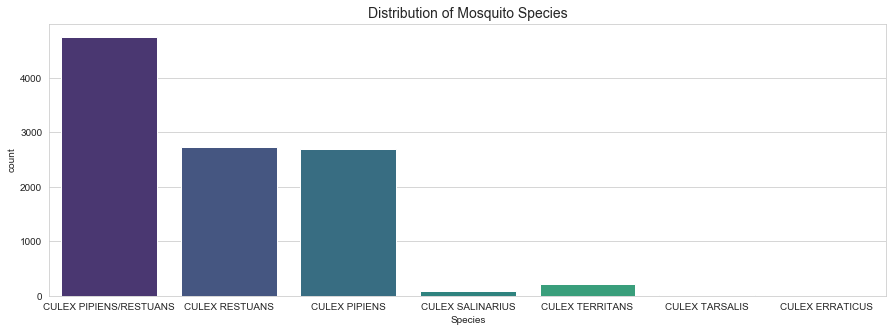

In [94]:
plt.figure(figsize=(15,5))
sns.countplot(x="Species", data=trainDf, palette="viridis")
plt.title("Distribution of Mosquito Species", fontsize=14)
plt.show()


The plot shows that the majority of the mosquitos caught were culex restuans and culex pipens

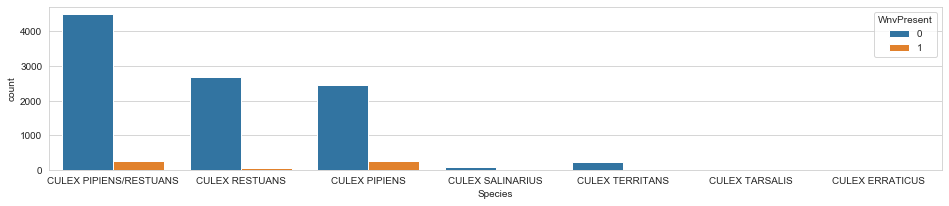

In [95]:
plt.subplots(figsize=(16,3))
sns.countplot('Species',data=trainDf,hue='WnvPresent',)

Culex Pipiens appears to be the main carrier of West Nile Virus as it is most commonly associated with the presence of west nile virus as seen in the plot above

## Distributions in Traps

In [96]:
trainDf.Trap.value_counts()

T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T094B      5
T076       5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64

Some traps are satellite traps. These traps are set up near an established trap to futher enhance surveillance efforts. They are denoted by Letters eg T220A.
We will combine the satellite to the main trap so as to get lesser unique values


In [97]:
def trap_data(x):
    x['Trap']=x['Trap'].apply(lambda x: x.replace('A','').replace('B','').replace('C',''))
    return x

In [98]:
trainDf=trap_data(trainDf)

In [99]:
trainDf['Trap'].value_counts()

T900    750
T115    542
T138    314
T002    185
T135    183
       ... 
T078      8
T238      7
T076      5
T237      3
T040      2
Name: Trap, Length: 134, dtype: int64

In [100]:
#now i want to find how many traps have more than 10 positive results of WNV

In [101]:
trap_coords=trainDf[['Trap','Latitude','Longitude']].drop_duplicates()
mosq_by_trap = trainDf[['Trap','NumMosquitos','WnvPresent']].groupby('Trap').agg('sum')
mosq_by_trap.sort_values(by='WnvPresent', ascending=False, inplace=True)
mosq_by_trap.reset_index(inplace=True)
top_traps =mosq_by_trap[mosq_by_trap['WnvPresent']>10]
top_traps=pd.merge(top_traps, trap_coords,  how='left', left_on=['Trap'], right_on = ['Trap'])
top_traps


,Trap,NumMosquitos,WnvPresent,Latitude,Longitude
0,T900,15386,66,41.974689,-87.890615
1,T115,21668,41,41.673408,-87.599862
2,T002,3710,18,41.954690,-87.800991
3,T138,9936,16,41.726465,-87.585413
4,T003,1346,14,41.964242,-87.757639
5,T011,1311,11,41.944869,-87.832763
6,T225,2014,11,41.743402,-87.731435
7,T128,3315,11,41.704572,-87.565666


Only 8 out of 134 traps have more than 10 positive results of West Nile Virus

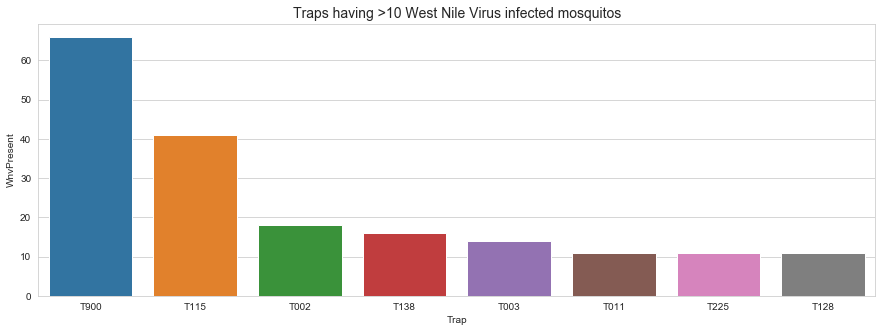

In [102]:
plt.figure(figsize=(15,5))
sns.barplot(data=mosq_by_trap[mosq_by_trap['WnvPresent']>10], x='Trap', y='WnvPresent')#, hue='Date')
plt.title("Traps having >10 West Nile Virus infected mosquitos", fontsize=14)
plt.show()

In [103]:
species_counts = trainDf.groupby('Species').sum()['WnvPresent'].copy()

species_pct_wnv = trainDf.groupby('Species').sum()['WnvPresent']/trainDf.groupby('Species').count()['WnvPresent'].copy()

[Text(0.5, 1.0, '% of Trapped Mosquitos with West Nile virus')]

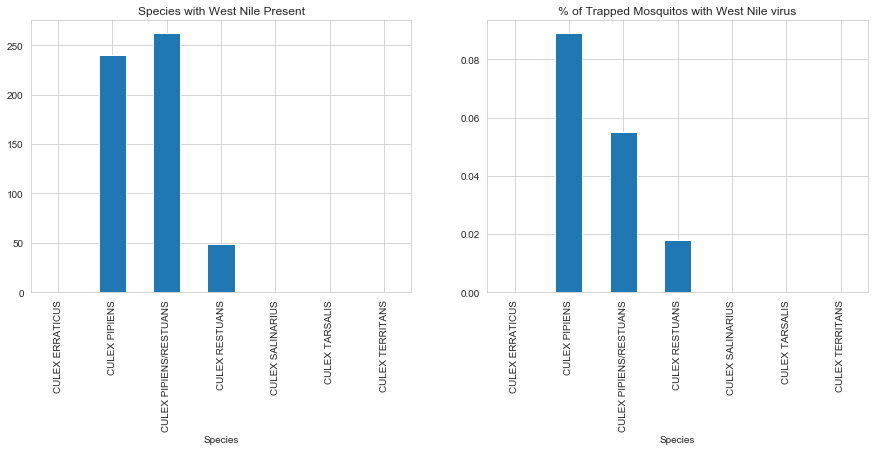

In [104]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

species_counts.plot(kind='bar', ax=ax1)

# Add labels to the plot
ax1.set(title="Species with West Nile Present")

species_pct_wnv.plot(kind='bar', ax=ax2)
ax2.set(title="% of Trapped Mosquitos with West Nile virus") # xlabel='Standardized Salaries', ylabel='Winning Percentage')

## Visualising Trap Locations

In [105]:
BBox = ((trainDf.Longitude.min(),   trainDf.Longitude.max(),      
         trainDf.Latitude.min(), trainDf.Latitude.max()))
BBox

(-87.930995, -87.531635, 41.644612, 42.01743)

In [106]:
mapdata = np.loadtxt("./mapdata_copyright_openstreetmap_contributors.txt")

In [107]:
trainDf = pd.read_csv('./assets/trainSprayCombinedWeather.csv')

In [108]:
trainDf

,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Most_Recent_Spray,Recently_Sprayed,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Weather_hotAndDry,Weather_normal,Day_of_Month,Month,Year,Day_of_Week
0,0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
1,1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
2,2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
3,3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
4,4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,10501,2013-09-26,CULEX PIPIENS/RESTUANS,T035,41.764,-87.742,8,6,1,3650.0,0,75,55,65,52,58.0,0,0,0.0,29.40,30.04,4.1,9,4.6,0,1,26,9,2013,3
10502,10502,2013-09-26,CULEX PIPIENS/RESTUANS,T231,41.987,-87.666,8,5,0,3650.0,0,75,55,65,52,58.0,0,0,0.0,29.40,30.04,4.1,9,4.6,0,1,26,9,2013,3
10503,10503,2013-09-26,CULEX PIPIENS/RESTUANS,T232,41.913,-87.668,9,1,0,3650.0,0,75,55,65,52,58.0,0,0,0.0,29.40,30.04,4.1,9,4.6,0,1,26,9,2013,3
10504,10504,2013-09-26,CULEX PIPIENS/RESTUANS,T233,42.010,-87.807,9,5,0,21.0,1,75,50,63,52,58.0,2,0,0.0,29.34,30.04,3.8,8,4.2,0,0,26,9,2013,3


In [109]:
locations=trainDf[trainDf['Year']==2011][['Latitude','Longitude']]
locations.head()

,Latitude,Longitude
6060,41.896,-87.655
6061,41.721,-87.666
6062,42.017,-87.688
6063,41.987,-87.690
6064,41.801,-87.763


In [110]:
df_weather_stations=pd.DataFrame({
    'Station':[1,2],
    'Latitude':[41.995, 41.786],
    'Longitude':[-87.933, -87.752]
})
df_weather_stations

,Station,Latitude,Longitude
0,1,41.995,-87.933
1,2,41.786,-87.752


In [111]:
spray = pd.read_csv('./assets/sprayDf.csv')

In [112]:
def plot_map_for_yr(X, yr):
    df_yr = X[X['Year']==yr]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)

    locations = df_yr[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x', c='black')

    locations_wnv = df_yr[df_yr['WnvPresent']==1][['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_wnv[:,0], locations_wnv[:,1], marker='o', c='red')

    locations_weather = df_weather_stations[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_weather[:,0], locations_weather[:,1], marker="D", c='green')
    
    if yr==2011:
        #include spray location
        df_2011 = trainDf[trainDf['Year']==2011]
        df_spray__2011 =spray[(spray['Date']==2011)]
        locations_spray = df_spray__2011[['Longitude', 'Latitude']].drop_duplicates().values
        plt.scatter(locations_spray[:,0], locations_spray[:,1], marker="4", c='yellow')
        
    # plot our top ten most WNV-associated traps
    
    locations_top_traps = top_traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_top_traps[:,0], locations_top_traps[:,1], marker="D", c='blue')
    
    plt.title(yr)

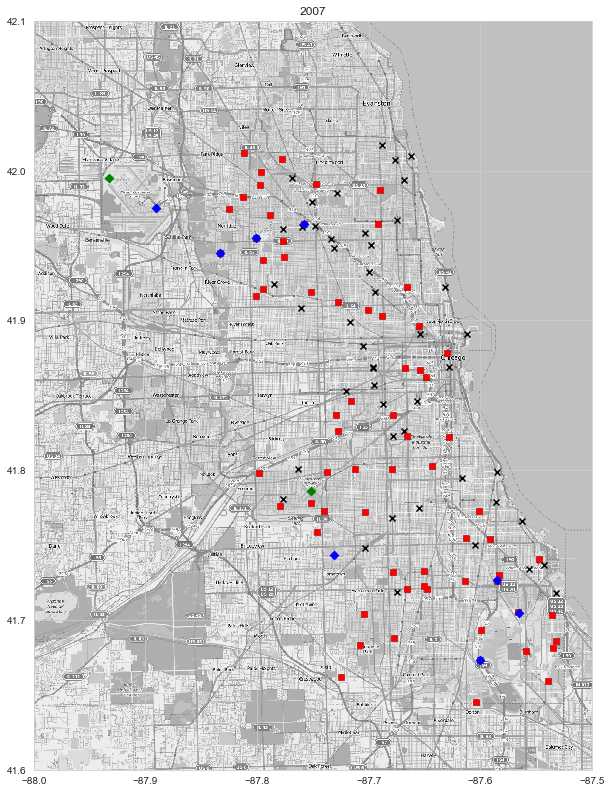

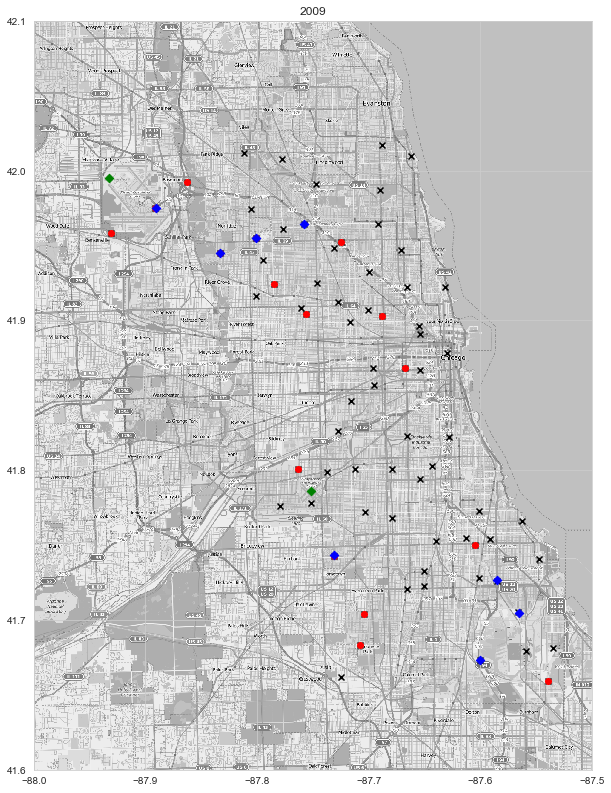

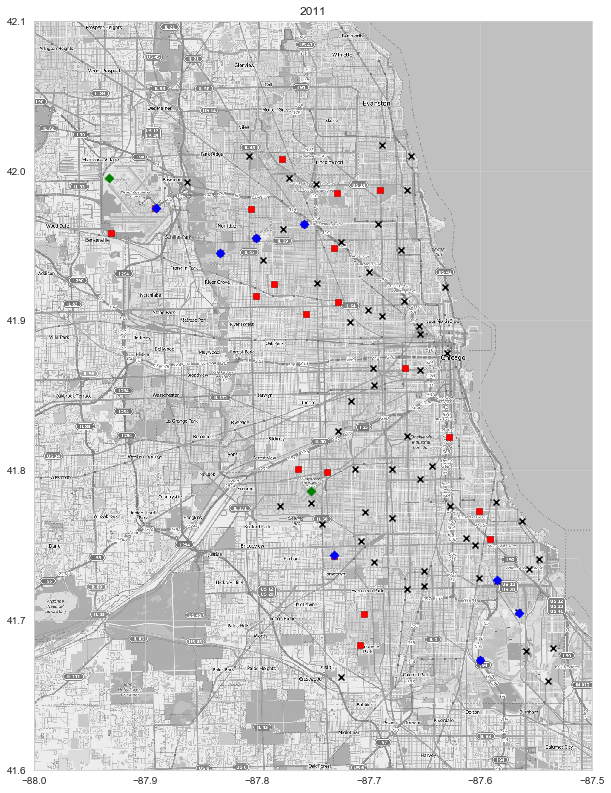

In [113]:
for ayear in [2007, 2009, 2011]:
    plot_map_for_yr(trainDf, ayear)

<b>LEGEND</b>

<br>red square: west nile virus detected
<br>black X: trap location
<br>blue circle: "Top Trap" for west nile virus association
<br>green circle: weather station
    


Observations:
    
We can generally see the that the traps where the top counts of WNV present (blue circle) are clustered nearby to each other.

## Check correlations of columns to WNEpresent particularly from weather data columns and spray data columns

In [114]:
trainDf.corrwith(trainDf['WnvPresent'])

Unnamed: 0           0.066676
Latitude             0.028708
Longitude           -0.060389
AddressAccuracy      0.008064
NumMosquitos         0.196820
WnvPresent           1.000000
Most_Recent_Spray   -0.023134
Recently_Sprayed     0.015186
Tmax                 0.047130
Tmin                 0.065705
Tavg                 0.059897
DewPoint             0.082685
WetBulb              0.077539
Heat                -0.052818
Cool                 0.053347
PrecipTotal          0.028411
StnPressure         -0.004663
SeaLevel             0.010163
ResultSpeed         -0.043413
ResultDir           -0.003530
AvgSpeed            -0.031043
Weather_hotAndDry   -0.008478
Weather_normal      -0.051531
Day_of_Month         0.008245
Month                0.100143
Year                 0.050865
Day_of_Week          0.014968
dtype: float64

## Distribution of Mosquito species by year

In [115]:
trainDf.head()

,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Most_Recent_Spray,Recently_Sprayed,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Weather_hotAndDry,Weather_normal,Day_of_Month,Month,Year,Day_of_Week
0,0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
1,1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
2,2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
3,3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
4,4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1


In [116]:
mosq_by_year = trainDf[['Year','Species','NumMosquitos','WnvPresent']].groupby(['Year','Species']).agg('sum')
mosq_by_year.reset_index(inplace=True)
mosq_by_year


,Year,Species,NumMosquitos,WnvPresent
0,2007,CULEX PIPIENS,35871,147
1,2007,CULEX PIPIENS/RESTUANS,20565,83
2,2007,CULEX RESTUANS,1847,6
3,2007,CULEX SALINARIUS,61,0
4,2007,CULEX TERRITANS,344,0
5,2009,CULEX PIPIENS,867,0
6,2009,CULEX PIPIENS/RESTUANS,15531,13
7,2009,CULEX RESTUANS,4657,6
8,2009,CULEX SALINARIUS,26,0
9,2009,CULEX TARSALIS,2,0


[Text(0.5, 1.0, 'Presences of West Nile Virus per Species')]

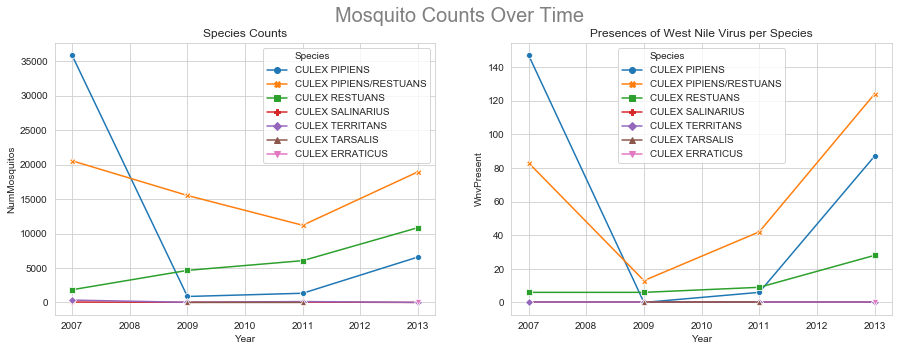

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
fig.suptitle('Mosquito Counts Over Time', ha='center',color = 'grey',fontsize=20,va='top',) 

sns.lineplot(ax=ax1,data=mosq_by_year,x='Year',y='NumMosquitos',hue='Species', style='Species', markers=True,dashes=False)
ax1.set(title="Species Counts")

sns.lineplot(ax=ax2,data=mosq_by_year,x='Year',y='WnvPresent',hue='Species', style='Species', markers=True,dashes=False)
ax2.set(title="Presences of West Nile Virus per Species")

We can see from the above plots that:
    
For mosquito numbers:
<br>-Culex Pipiens numbers dropped off rapidly in 2009 and 2011, but started to rise again in 2011 to 2013
<br>-Culex restuans has a steady increase in numbers over time
<br>-The general trend is that all species except Terraritans,Tarsalis are increasing from 2011 to 2013.



For Positive West Nile Counts:
<br>-numbers have been increasing from 2009 onwards.
<br>-in 2013,the WNV is observed in Culex Pipiens, Culex Pipiens/Restuans, Culex Restuans

## Distribution of Mosquito species in each year

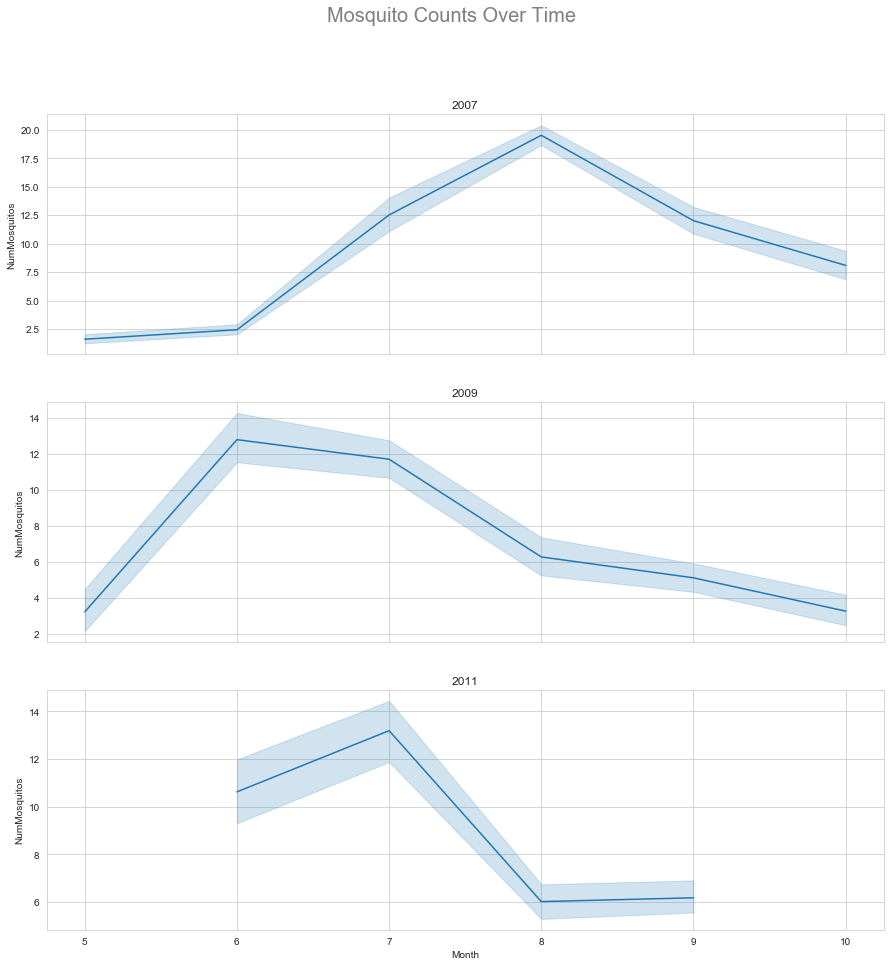

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15),sharex=True)
fig.suptitle('Mosquito Counts Over Time', ha='center',color = 'grey',fontsize=20,va='top',) 
cnt=0
for ayear in [2007, 2009, 2011]:
    sns.lineplot(ax=ax[cnt], data=trainDf[(trainDf['Year']==ayear)],x='Month',y='NumMosquitos')#,hue='Species')
    ax[cnt].set(title=ayear)
    cnt = cnt+1

-in 2007, mosquito counts peaked in August, 
<br>-in 2009, they peaked much earlier in June
<br>-2011 also showed a peak in July
<br>-Somehow over the years, the peak period tend to shift earlier, is there a reason for this ??

## Comparing Weather across the Years

In [119]:
def plot_time_charts(X, x_col, y_col,title):
    fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15), sharey=True)

    fig.suptitle(title, ha='center',color = 'grey',fontsize=20,va='top',) 
    cnt=0
    for ayear in [2007, 2009, 2011]:
        sns.lineplot(ax=ax[cnt], data=X[(X['Year']==ayear)],x=x_col,y=y_col)
        ax[cnt].set(title=ayear)
        cnt = cnt+1

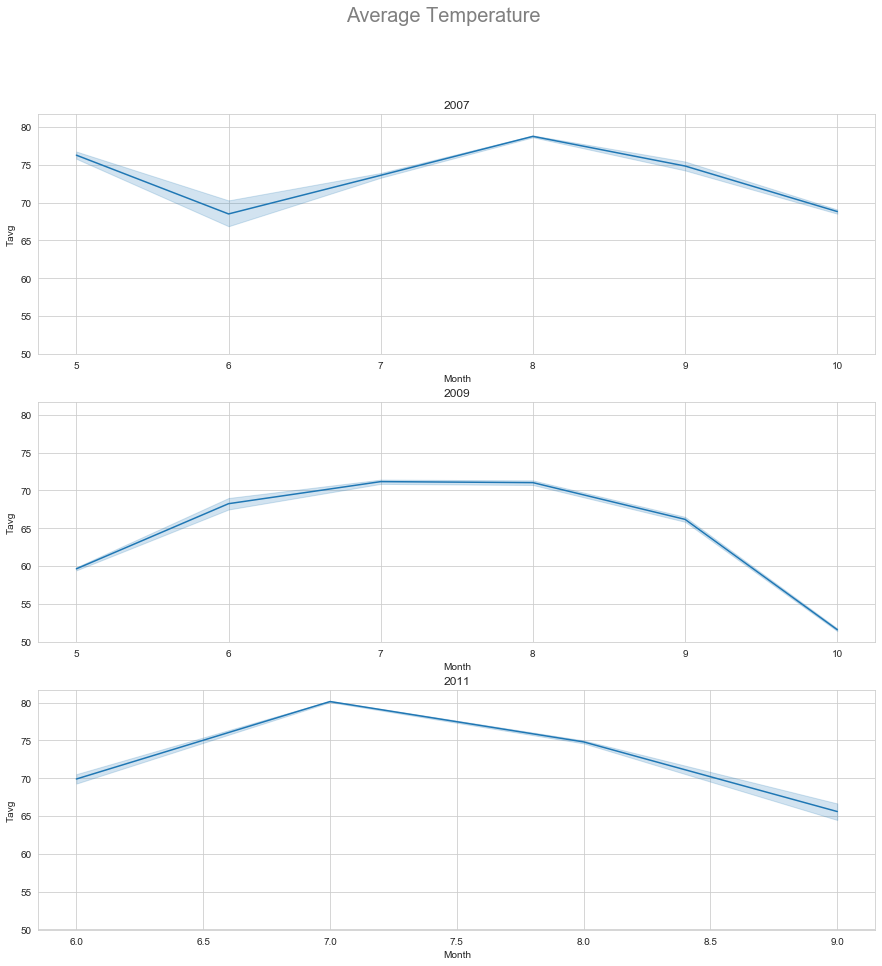

In [120]:
plot_time_charts(trainDf, 'Month', 'Tavg','Average Temperature')

From the average temperature recorded throughout each year:

<br>The peak temperature in 2007 was recorded in Auguest, while the peak <br>temperatures in 2009 and 2011 were recorded between june and july.

<br>This corresponded to the peak number of mosquitoes detected in the <br>respective years.

<br>This suggests that heat plays are part in the reproduction of mosquitoes

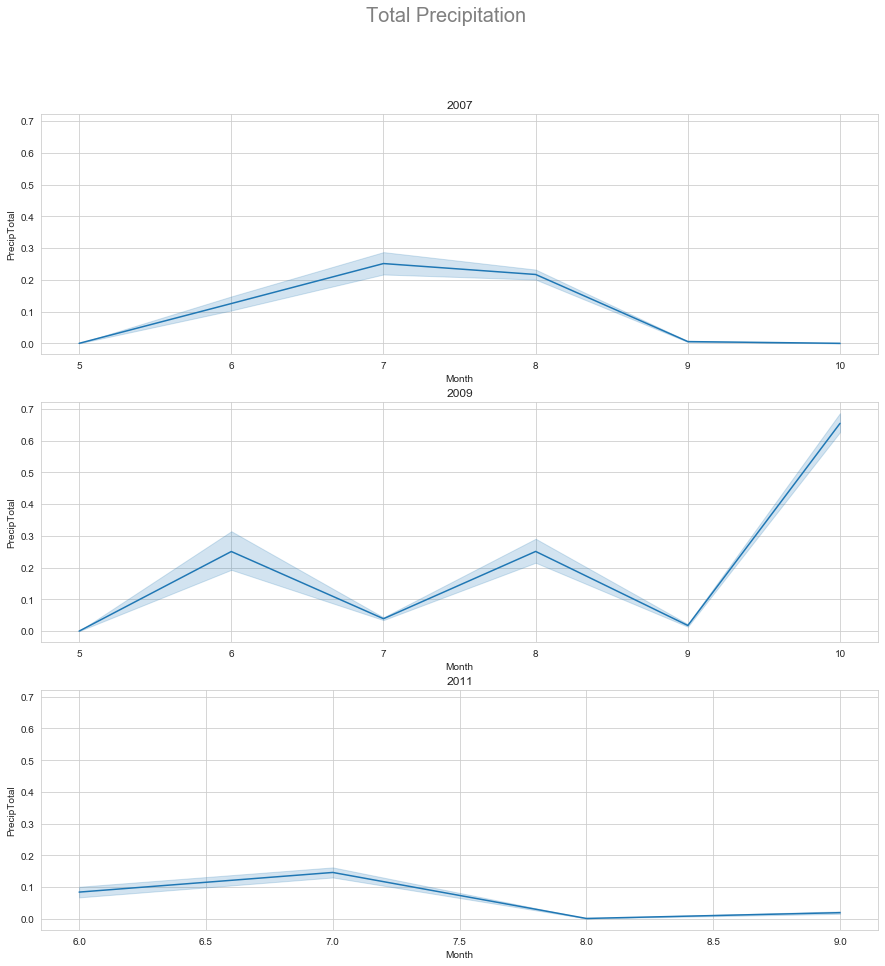

In [121]:
plot_time_charts(trainDf, 'Month', 'PrecipTotal','Total Precipitation')

The plot of precipitation does not really paint a clear picture.
<br>What it does that tell us that for all 3 years , precipation levels was low a the point of peak mosquito counts.

<br>This suggest mosquitos strive in dryer enviroments.

<br>Overall this in line with the data library that suggests that hot and dry conditions are ideal in mosquito breeding.

## Modelling and Kaggle Results

### Train Data Import

In [122]:
trainDf = pd.read_csv('./assets/trainSprayCombinedWeather.csv')

In [123]:
testDf = pd.read_csv('./assets/testDf.csv')

In [124]:
trainDf.head()

,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Most_Recent_Spray,Recently_Sprayed,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Weather_hotAndDry,Weather_normal,Day_of_Month,Month,Year,Day_of_Week
0,0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
1,1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
2,2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
3,3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1
4,4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,3650.0,0,88,60,74,58,65.0,0,9,0.0,29.39,30.11,5.8,18,6.5,0,0,29,5,2007,1


In [125]:
trainDf.columns

Index(['Unnamed: 0', 'Date', 'Species', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Most_Recent_Spray',
       'Recently_Sprayed', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Weather_hotAndDry', 'Weather_normal',
       'Day_of_Month', 'Month', 'Year', 'Day_of_Week'],
      dtype='object')

In [126]:
trainDf.shape

(10506, 30)

In [127]:
trainDf = pd.get_dummies(trainDf, prefix = ['Species'], columns = ['Species'] ,drop_first = True)

In [128]:
trainDf.drop(columns=['Date', 'Latitude', 'Longitude', 'Trap', 'AddressAccuracy', 'Day_of_Month', 'Year', 
                      'Most_Recent_Spray', 'Tmin', 'Tavg', 'Heat','Cool', 'SeaLevel' ,'Day_of_Week', 'Year', 'Day_of_Month'], axis =1, inplace =True)

In [129]:
trainDf.shape

(10506, 21)

In [130]:
trainDf.columns

Index(['Unnamed: 0', 'NumMosquitos', 'WnvPresent', 'Recently_Sprayed', 'Tmax',
       'DewPoint', 'WetBulb', 'PrecipTotal', 'StnPressure', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Weather_hotAndDry', 'Weather_normal', 'Month',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

### Test Data Import

In [131]:
testDf = pd.read_csv('./assets/testDf.csv')

In [132]:
testDf.head()

,Id,Date,Latitude,Longitude,AddressAccuracy,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,Most_Recent_Spray,Recently_Sprayed,Tmax,...,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day_of_Month,Month,Year,Day_of_Week,Weather_hotAndDry,Weather_normal
0,1,2008-06-11,41.955,-87.801,9,0,1,0,0,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
1,2,2008-06-11,41.955,-87.801,9,0,0,1,0,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
2,3,2008-06-11,41.955,-87.801,9,1,0,0,0,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
3,4,2008-06-11,41.955,-87.801,9,0,0,0,1,0,0,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1
4,5,2008-06-11,41.955,-87.801,9,0,0,0,0,0,1,0,3650.0,0,86,...,0,9,,0.0,29.28,29.99,8.9,18,10.0,11,6,2008,2,0,1


In [133]:
testDf.shape

(116293, 34)

In [134]:
testDf.drop(columns=['Id', 'Latitude', 'Longitude', 'Date', 'AddressAccuracy', 'Day_of_Month', 'Year', 'CodeSum',
                      'Most_Recent_Spray', 'Tmin', 'Tavg', 'Heat','Cool', 'SeaLevel' ,'Day_of_Week', 'Year', 'Day_of_Month'], axis =1, inplace =True)

In [135]:
testDf.shape

(116293, 19)

In [136]:
testDf.columns

Index(['Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS',
       'Species_UNSPECIFIED CULEX', 'Recently_Sprayed', 'Tmax', 'DewPoint',
       'WetBulb', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Month', 'Weather_hotAndDry', 'Weather_normal'],
      dtype='object')

### Preprocessing & Modeling

In [137]:
#assign target and result to y and X for training set then carry out train test split
X = trainDf.drop(columns=['WnvPresent', 'Unnamed: 0'])
y = trainDf.WnvPresent

In [138]:
X

,NumMosquitos,Recently_Sprayed,Tmax,DewPoint,WetBulb,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,Weather_hotAndDry,Weather_normal,Month,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,1,0,88,58,65.0,0.0,29.39,5.8,18,6.5,0,0,5,0,1,0,0,0,0
1,1,0,88,58,65.0,0.0,29.39,5.8,18,6.5,0,0,5,0,0,1,0,0,0
2,1,0,88,58,65.0,0.0,29.39,5.8,18,6.5,0,0,5,0,0,1,0,0,0
3,1,0,88,58,65.0,0.0,29.39,5.8,18,6.5,0,0,5,0,1,0,0,0,0
4,4,0,88,58,65.0,0.0,29.39,5.8,18,6.5,0,0,5,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,6,0,75,52,58.0,0.0,29.40,4.1,9,4.6,0,1,9,0,1,0,0,0,0
10502,5,0,75,52,58.0,0.0,29.40,4.1,9,4.6,0,1,9,0,1,0,0,0,0
10503,1,0,75,52,58.0,0.0,29.40,4.1,9,4.6,0,1,9,0,1,0,0,0,0
10504,5,1,75,52,58.0,0.0,29.34,3.8,8,4.2,0,0,9,0,1,0,0,0,0


In [139]:
#assign target and result to y and X for test set
X_testset = testDf
y = trainDf.WnvPresent

In [140]:
# Import train_test_split.
from sklearn.model_selection import train_test_split

# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Baseline Accuracy 

In [141]:
y.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

#### Train/Test Split

In [142]:
X_train

,NumMosquitos,Recently_Sprayed,Tmax,DewPoint,WetBulb,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,Weather_hotAndDry,Weather_normal,Month,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
10188,3,0,83,58,64.0,0.060,29.34,6.8,34,9.8,0,1,9,1,0,0,0,0,0
7201,21,0,84,68,71.0,0.005,29.26,5.2,7,6.0,0,1,8,0,1,0,0,0,0
4018,3,0,80,43,54.0,0.000,29.23,6.3,25,7.2,0,1,6,0,1,0,0,0,0
7343,7,0,81,59,64.0,0.000,29.22,8.3,19,8.5,0,1,8,0,1,0,0,0,0
5402,3,0,86,55,63.0,0.000,29.44,2.0,16,4.0,0,1,8,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,50,0,90,65,70.0,0.000,29.34,7.8,21,8.3,0,1,8,1,0,0,0,0,0
1009,2,0,91,63,70.0,0.000,29.34,2.1,13,3.7,0,1,8,1,0,0,0,0,0
999,1,0,91,63,70.0,0.000,29.34,2.1,13,3.7,0,1,8,1,0,0,0,0,0
4894,4,0,83,59,64.0,0.140,29.08,8.9,23,9.8,0,0,7,1,0,0,0,0,0


In [143]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#### Balance Classes: Oversampling (SMOTE)

In [144]:
# Oversampling on training data only
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

In [145]:
print(X_res.shape)
print(y_res.shape)

(13936, 19)
(13936,)


#### Test/Train Split

In [146]:
# Create train_test_split after oversampling
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [147]:
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(9755, 19)
(9755,)
(4181, 19)
(4181,)


#### Logistic Regression

In [148]:
##logreg = LogisticRegression()
##logreg.fit(X_train_2, y_train_2)

In [149]:
##cross_val_score(logreg, X_train_2, y_train_2, cv=5).mean()

In [150]:
# Grid search cross validation

##grid={"C":np.logspace(-4, 4, 50), "penalty":["l1","l2"]}# l1 lasso l2 ridge
##logreg=LogisticRegression()
##logreg_cv=GridSearchCV(logreg,grid,cv=5)
##logreg_cv.fit(X_train_2,y_train_2)

##print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
##print("accuracy :",logreg_cv.best_score_)


#### Random Forest

In [151]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [152]:
cross_val_score(rf, X_train_2, y_train_2, cv=5).mean()

0.9241414659149154

In [153]:
y_preds = rf.predict(X_test)
print(classification_report(y_test, y_preds))
pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2987
           1       0.20      0.37      0.26       165

    accuracy                           0.89      3152
   macro avg       0.58      0.64      0.60      3152
weighted avg       0.92      0.89      0.90      3152



,Predicted Negative,Predicted Positive
Actual Negative,2744,243
Actual Positive,104,61


In [154]:
zipped = list(zip(X.columns.values, rf.feature_importances_))
sorted_importance = sorted(zipped, key=itemgetter(1), reverse=True)
sorted_importance

[('NumMosquitos', 0.40547658620404353),
 ('Month', 0.14189199576148173),
 ('Tmax', 0.05813450231418113),
 ('ResultSpeed', 0.05551568337837255),
 ('WetBulb', 0.05276418453535923),
 ('AvgSpeed', 0.05126030609374614),
 ('DewPoint', 0.04749280724082517),
 ('StnPressure', 0.0419679470275875),
 ('ResultDir', 0.041392977928078535),
 ('Species_CULEX RESTUANS', 0.02696027289355901),
 ('PrecipTotal', 0.022891300745884316),
 ('Species_CULEX PIPIENS', 0.02060109689158618),
 ('Species_CULEX PIPIENS/RESTUANS', 0.016678149492557613),
 ('Weather_normal', 0.010138266098686342),
 ('Recently_Sprayed', 0.0033735150970822534),
 ('Species_CULEX TERRITANS', 0.002181131239681007),
 ('Weather_hotAndDry', 0.0011606151675742139),
 ('Species_CULEX SALINARIUS', 0.00011323712998398939),
 ('Species_CULEX TARSALIS', 5.424759729386335e-06)]

In [155]:
pd.DataFrame(sorted_importance[0:5], columns=['Feature', 'Importance'])

,Feature,Importance
0,NumMosquitos,0.405477
1,Month,0.141892
2,Tmax,0.058135
3,ResultSpeed,0.055516
4,WetBulb,0.052764


In [156]:
proba_pairs = rf.predict_proba(X_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.7973724523439958

#### Random Forest with GridSearch 

In [157]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split':[2, 5 ,10]
}

rf_gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose = 1,n_jobs = -1)
rf_gs.fit(X_train_2, y_train_2)
print(rf_gs.best_score_)
rf_gs.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   46.1s finished


0.9266017426960532


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

In [158]:
y_preds = rf_gs.predict(X_test)
print(classification_report(y_test, y_preds))
pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2987
           1       0.22      0.45      0.29       165

    accuracy                           0.89      3152
   macro avg       0.59      0.68      0.61      3152
weighted avg       0.93      0.89      0.90      3152



,Predicted Negative,Predicted Positive
Actual Negative,2718,269
Actual Positive,91,74


In [159]:
proba_pairs = rf_gs.predict_proba(X_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.8161913747451075

#### Random Forest with RandomizedSearch

In [160]:
rf_rand = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=5, n_iter=50, random_state=42, n_jobs = -1, verbose = 1)
rf_rand.fit(X_train_2, y_train_2)
print(rf_rand.best_score_)
rf_rand.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   43.0s finished


0.9273193234238851


{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}

In [161]:
y_preds = rf_rand.predict(X_test)
print(classification_report(y_test, y_preds))
pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2987
           1       0.21      0.44      0.29       165

    accuracy                           0.89      3152
   macro avg       0.59      0.67      0.61      3152
weighted avg       0.93      0.89      0.90      3152



,Predicted Negative,Predicted Positive
Actual Negative,2719,268
Actual Positive,93,72


In [162]:
proba_pairs = rf_rand.predict_proba(X_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.8202808128151282

#### Comparing ROC AUC Scores

1. Random Forest is 0.7973724523439958
2. Random Forest with GridSearch is 0.8202808128151282
3. Random Forest with RandomizedSearch is 0.8161913747451075

Since Random Forest with GridSearch has the highest ROC AUC Score, we will be moving forth with it.

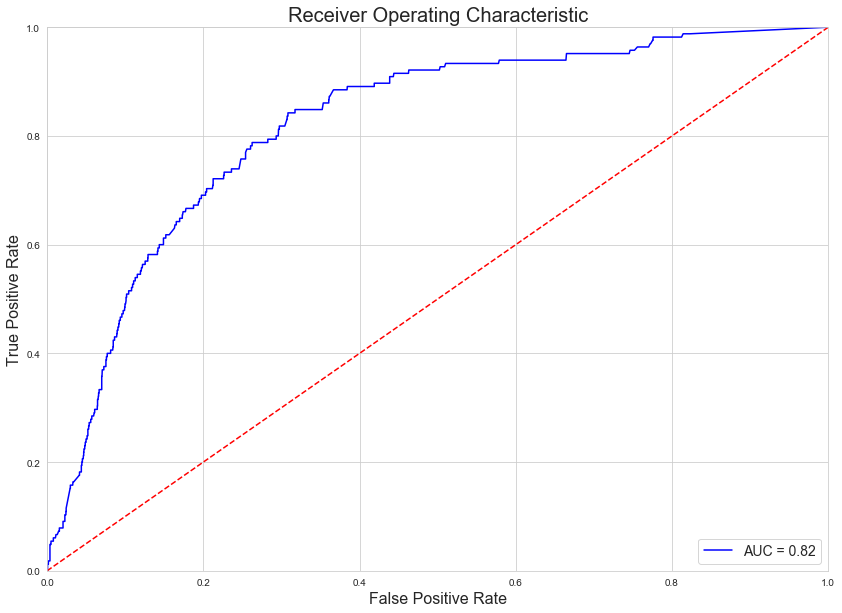

In [163]:
fpr, tpr, threshold = roc_curve(y_test, probas)

roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(figsize=(14,10))

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

### Kaggle Submission

In [164]:
X_testset = ss.transform(X_testset)

In [165]:
proba_pairs = rf_rand.predict_proba(X_testset)
probas = [item[1] for item in proba_pairs]

In [166]:
submission = pd.DataFrame(probas)

In [167]:
submission.index += 1

In [168]:
submission.head()

,0
1,0.090912
2,0.090912
3,0.090912
4,0.090912
5,0.105549


In [169]:
submission.rename(columns={0: "WnvPresent"}, inplace=True)

In [170]:
submission.head()

,WnvPresent
1,0.090912
2,0.090912
3,0.090912
4,0.090912
5,0.105549


In [171]:
submission.reset_index(level=0, inplace=True)
submission.rename(columns={"index": "ID"}, inplace=True)
submission.head()

,ID,WnvPresent
0,1,0.090912
1,2,0.090912
2,3,0.090912
3,4,0.090912
4,5,0.105549


In [172]:
submission.to_csv('./assets/kaggle_submission.csv', index=False)

We've obtained a Kaggle Submission Score of 0.56882

Possible ways of improving the model will be including features for cumulative weather conditions:

1. Average temperature over the past week
2. Average precipitation over the past week 
3. Number of days without preciptiation.